# Heatmap de la Activacion

In [1]:
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**se carga el modelo (para prediccion)**

In [2]:
from keras.applications.vgg16 import VGG16
from keras import backend as K

model = VGG16(weights='imagenet')

Using TensorFlow backend.


In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

import numpy as np

In [4]:
img_path = 'data/dream.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

x.shape

(1, 224, 224, 3)

In [5]:
preds = model.predict(x)

In [6]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n06596364', 'comic_book', 0.5218218), ('n07248320', 'book_jacket', 0.17583802), ('n10565667', 'scuba_diver', 0.061058108)]


In [7]:
a_max=np.argmax(preds[0])
a_max

917

In [8]:
output = model.output[:, a_max]

In [9]:
last_conv_layer = model.get_layer('block5_conv3')

In [11]:
grads = K.gradients(output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])


pooled_grads_value, conv_layer_output_value = iterate([x])


for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

**post-processing**

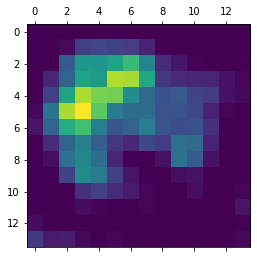

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap);

## Superponiendo Heatmap a imagen original

In [14]:
import cv2

img=cv2.imread(img_path)  # se lee

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # redimensionado
heatmap = np.uint8(255 * heatmap)                        # rgb
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)   # heatmap

superimposed_img = heatmap * 0.4 + img   # heatmap con 0.4 de intensidad


cv2.imwrite('data/img_heatmap.jpg', superimposed_img) # se guarda

True

In [15]:
cv2.imshow('img_heatmap', img)